In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

np.random.seed(42)

In [2]:
def train_val_test_split(X, y):
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    classes = np.unique(y)
    for c in classes:
        Xc = X[y == c]
        yc = y[y == c]
        
        n = len(Xc)
        idx = np.random.permutation(n)
        
        train_end = int(0.6 * n)
        val_end = int(0.8 * n)
        
        X_train.append(Xc[idx[:train_end]])
        y_train.append(yc[idx[:train_end]])
        
        X_val.append(Xc[idx[train_end:val_end]])
        y_val.append(yc[idx[train_end:val_end]])
        
        X_test.append(Xc[idx[val_end:]])
        y_test.append(yc[idx[val_end:]])
    
    return (np.vstack(X_train), np.hstack(y_train),
            np.vstack(X_val), np.hstack(y_val),
            np.vstack(X_test), np.hstack(y_test))


In [3]:
def one_hot(y, num_classes):
    oh = np.zeros((len(y), num_classes))
    oh[np.arange(len(y)), y] = 1
    return oh

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)

In [5]:
class FCNN:
    def __init__(self, layers, lr=0.01):
        self.layers = layers
        self.lr = lr
        self.weights = []
        self.biases = []
        
        for i in range(len(layers)-1):
            self.weights.append(np.random.randn(layers[i], layers[i+1]) * 0.1)
            self.biases.append(np.zeros((1, layers[i+1])))
    
    def forward(self, X):
        activations = [X]
        zs = []
        for W, b in zip(self.weights, self.biases):
            z = activations[-1] @ W + b
            zs.append(z)
            activations.append(sigmoid(z))
        return activations, zs
    
    def backward(self, X, y):
        activations, zs = self.forward(X)
        deltas = [None] * len(self.weights)
        
        deltas[-1] = (activations[-1] - y) * sigmoid_deriv(zs[-1])
        
        for i in reversed(range(len(deltas)-1)):
            deltas[i] = (deltas[i+1] @ self.weights[i+1].T) * sigmoid_deriv(zs[i])
        
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * activations[i].T @ deltas[i]
            self.biases[i] -= self.lr * np.sum(deltas[i], axis=0, keepdims=True)
        
        return np.mean((activations[-1] - y)**2)
    
    def predict(self, X):
        a, _ = self.forward(X)
        return np.argmax(a[-1], axis=1)


In [6]:
class SingleNeuron:
    def __init__(self, input_dim, output_dim, lr=0.01):
        self.W = np.random.randn(input_dim, output_dim) * 0.1
        self.b = np.zeros((1, output_dim))
        self.lr = lr
    
    def forward(self, X):
        return sigmoid(X @ self.W + self.b)
    
    def train(self, X, y, epochs=200):
        errors = []
        for _ in range(epochs):
            out = self.forward(X)
            error = (out - y) * out * (1 - out)
            self.W -= self.lr * X.T @ error
            self.b -= self.lr * np.sum(error, axis=0, keepdims=True)
            errors.append(np.mean((out - y)**2))
        return errors
    
    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

In [7]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_predictions = model.predict(grid)
    Z = grid_predictions.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()

Linear Data

In [8]:
X1, y1 = make_blobs(n_samples=1500, centers=3, n_features=2, cluster_std=1.2, random_state=42)
X1_train, y1_train, X1_val, y1_val, X1_test, y1_test = train_val_test_split(X1, y1)
y1_train_oh = one_hot(y1_train, 3)
y1_val_oh = one_hot(y1_val, 3)
y1_test_oh = one_hot(y1_test, 3)

In [9]:
fcnn1 = FCNN([2, 15, 10, 3], lr=0.01)
errors1 = []
for epoch in range(200):
    err = fcnn1.backward(X1_train, y1_train_oh)
    errors1.append(err)

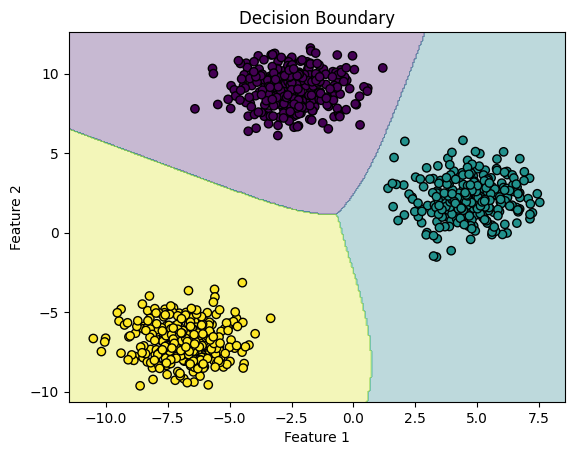

In [10]:
plot_decision_boundary(fcnn1, X1_train, y1_train)

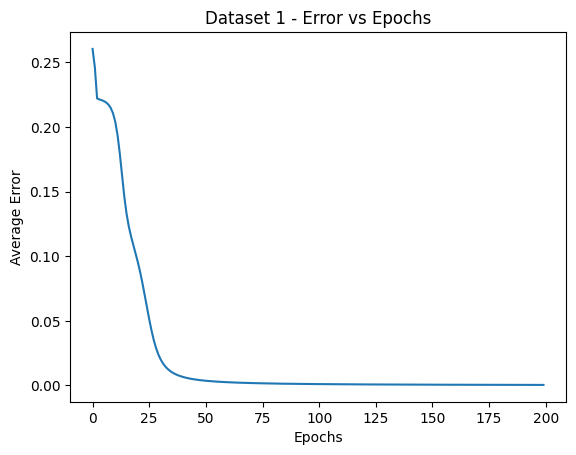

In [11]:
plt.figure()
plt.plot(errors1)
plt.xlabel("Epochs")
plt.ylabel("Average Error")
plt.title("Dataset 1 - Error vs Epochs")
plt.show()

In [12]:
fcnn1_val_predictions = fcnn1.predict(X1_val)
fcnn1_val_confusion_matrix = confusion_matrix(y1_val, fcnn1_val_predictions)
fcnn1_val_accuracy = accuracy_score(y1_val, fcnn1_val_predictions)

In [13]:
print("FCNN - Dataset 1 - Validation Confusion Matrix")
print(fcnn1_val_confusion_matrix)
print("Validation Accuracy:", fcnn1_val_accuracy)

FCNN - Dataset 1 - Validation Confusion Matrix
[[100   0   0]
 [  0 100   0]
 [  0   0 100]]
Validation Accuracy: 1.0


In [14]:
fcnn1_test_predictions = fcnn1.predict(X1_test)
fcnn1_test_confusion_matrix = confusion_matrix(y1_test, fcnn1_test_predictions)
fcnn1_test_accuracy = accuracy_score(y1_test, fcnn1_test_predictions)

In [15]:
print("FCNN - Dataset 1 - Test Confusion Matrix")
print(fcnn1_test_confusion_matrix)
print("Test Accuracy:", fcnn1_test_accuracy)

FCNN - Dataset 1 - Test Confusion Matrix
[[100   0   0]
 [  0 100   0]
 [  0   0 100]]
Test Accuracy: 1.0


Non Linear Data

In [16]:
N = 1500
K = 3 
X2 = np.zeros((N*K, 2))
y2 = np.zeros(N*K, dtype=int)

for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.1   # noise level
    X2[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y2[ix] = j

X2_train, y2_train, X2_val, y2_val, X2_test, y2_test = train_val_test_split(X2, y2)
y2_train_oh = one_hot(y2_train, 3)
y2_val_oh = one_hot(y2_val, 3)
y2_test_oh = one_hot(y2_test, 3)

In [17]:
fcnn2 = FCNN([2, 15, 10, 3], lr=0.01)
errors2 = []
for epoch in range(300):
    err = fcnn2.backward(X2_train, y2_train_oh)
    errors2.append(err)

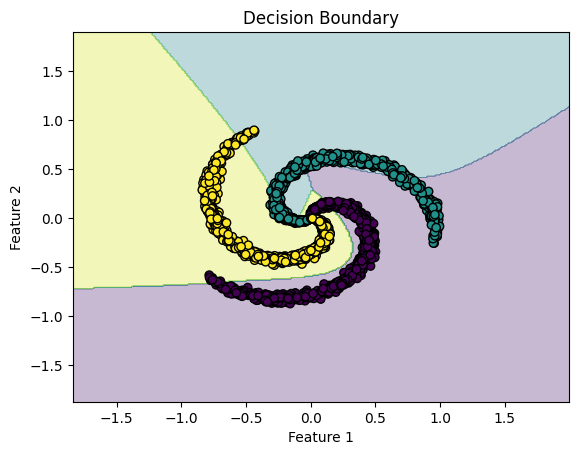

In [18]:
plot_decision_boundary(fcnn2, X2_train, y2_train)

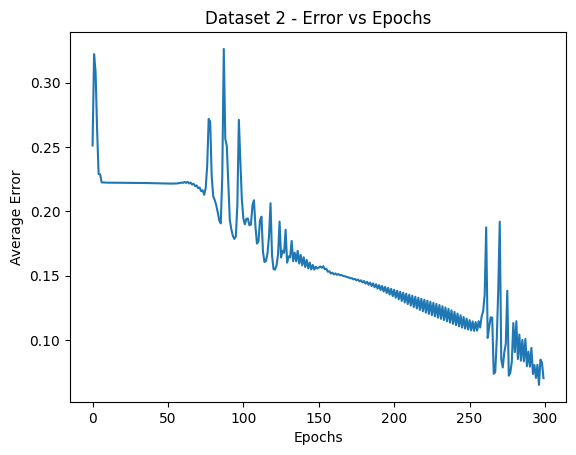

In [19]:
plt.figure()
plt.plot(errors2)
plt.xlabel("Epochs")
plt.ylabel("Average Error")
plt.title("Dataset 2 - Error vs Epochs")
plt.show()

In [20]:
fcnn2_val_predictions = fcnn2.predict(X2_val)
fcnn2_val_confusion_matrix = confusion_matrix(y2_val, fcnn2_val_predictions)
fcnn2_val_accuracy = accuracy_score(y2_val, fcnn2_val_predictions)

In [21]:
print("FCNN - Dataset 2 - Validation Confusion Matrix")
print(fcnn2_val_confusion_matrix)
print("Validation Accuracy:", fcnn2_val_accuracy)

FCNN - Dataset 2 - Validation Confusion Matrix
[[227   0  73]
 [ 62 177  61]
 [  0   3 297]]
Validation Accuracy: 0.7788888888888889


In [22]:
fcnn2_test_predictions = fcnn2.predict(X2_test)
fcnn2_test_confusion_matrix = confusion_matrix(y2_test, fcnn2_test_predictions)
fcnn2_test_accuracy = accuracy_score(y2_test, fcnn2_test_predictions)

In [23]:
print("FCNN - Dataset 2 - Test Confusion Matrix")
print(fcnn2_test_confusion_matrix)
print("Test Accuracy:", fcnn2_test_accuracy)


FCNN - Dataset 2 - Test Confusion Matrix
[[243   0  57]
 [ 67 179  54]
 [  0   3 297]]
Test Accuracy: 0.7988888888888889


Linear Data Single Neuron

In [24]:
sn1 = SingleNeuron(2, 3)
sn1.train(X1_train, y1_train_oh)
sn1_val_pred = sn1.predict(X1_val)
sn1_cm_val = confusion_matrix(y1_val, sn1_val_pred)
sn1_acc_val = accuracy_score(y1_val, sn1_val_pred)

In [25]:
print("Single Neuron - Dataset 1 - Validation Confusion Matrix")
print(sn1_cm_val)
print("Validation Accuracy:", sn1_acc_val)

Single Neuron - Dataset 1 - Validation Confusion Matrix
[[100   0   0]
 [  0 100   0]
 [  0   0 100]]
Validation Accuracy: 1.0


In [26]:
sn1_test_pred = sn1.predict(X1_test)
sn1_cm_test = confusion_matrix(y1_test, sn1_test_pred)
sn1_acc_test = accuracy_score(y1_test, sn1_test_pred)

In [27]:
print("\nSingle Neuron - Dataset 1 - Test Confusion Matrix")
print(sn1_cm_test)
print("Test Accuracy:", sn1_acc_test)


Single Neuron - Dataset 1 - Test Confusion Matrix
[[100   0   0]
 [  0 100   0]
 [  0   0 100]]
Test Accuracy: 1.0


Non Linear Data Single Neuron

In [28]:
sn2 = SingleNeuron(2, 3)
sn2.train(X2_train, y2_train_oh)
sn2_val_pred = sn2.predict(X2_val)
sn2_cm_val = confusion_matrix(y2_val, sn2_val_pred)
sn2_acc_val = accuracy_score(y2_val, sn2_val_pred)

In [29]:
print("\nSingle Neuron - Dataset 2 - Validation Confusion Matrix")
print(sn2_cm_val)
print("Validation Accuracy:", sn2_acc_val)


Single Neuron - Dataset 2 - Validation Confusion Matrix
[[146 116  38]
 [ 10 167 123]
 [119  18 163]]
Validation Accuracy: 0.5288888888888889


In [30]:
sn2_test_pred = sn2.predict(X2_test)
sn2_cm_test = confusion_matrix(y2_test, sn2_test_pred)
sn2_acc_test = accuracy_score(y2_test, sn2_test_pred)

In [31]:
print("\nSingle Neuron - Dataset 2 - Test Confusion Matrix")
print(sn2_cm_test)
print("Test Accuracy:", sn2_acc_test)


Single Neuron - Dataset 2 - Test Confusion Matrix
[[166 105  29]
 [ 11 175 114]
 [137  18 145]]
Test Accuracy: 0.54


In [32]:
comparison_table = pd.DataFrame({
    "Dataset": ["Linear (3 class)", "Nonlinear (3 class)"],
    "FCNN Validation Accuracy": [
        fcnn1_val_accuracy,
        fcnn2_val_accuracy
    ],
    "FCNN Test Accuracy": [
        fcnn1_test_accuracy,
        fcnn2_test_accuracy
    ],
    
    "Single Neuron Validation Accuracy": [
        sn1_acc_val,
        sn2_acc_val
    ],
    "Single Neuron Test Accuracy": [
        sn1_acc_test,
        sn2_acc_test
    ]
})

print("\nComparison Table (Validation + Test Accuracy)")
print(comparison_table)


Comparison Table (Validation + Test Accuracy)
               Dataset  FCNN Validation Accuracy  FCNN Test Accuracy  \
0     Linear (3 class)                  1.000000            1.000000   
1  Nonlinear (2 class)                  0.778889            0.798889   

   Single Neuron Validation Accuracy  Single Neuron Test Accuracy  
0                           1.000000                         1.00  
1                           0.528889                         0.54  
